In [68]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import json
import pickle
from tqdm import tqdm

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
from PIL import Image

In [69]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

import pandas as pd

# get predictors

In [3]:
name_0 = 'elias'
name_1 = 'neptune'

# name_0 = 'camel'
# name_1 = 'elephant'

# read scene file
# _path = '../../data/face_data/control_exp/20211011_Var6vbsl_set0_im151_camel_dur200ms_lab_updated.json'
_path = '../../data/face_data/20211011_Var6vbsl_set0_im151_elias/20211011_Var6vbsl_set0_im151_elias_dur200ms_lab_updated.json'
json_file_elias = json.load(open(_path, 'r'))

# _path = '../../data/face_data/control_exp/20211011_Var6vbsl_set0_im151_elephant_dur200ms_lab_updated.json'
_path = '../../data/face_data/20211011_Var6vbsl_set0_im151_neptune/20211011_Var6vbsl_set0_im151_neptune_dur200ms_lab_updated.json'
json_file_neptune = json.load(open(_path, 'r'))

In [4]:
# v - rotation_x, rotation_y
# b - background
# s - size
# p - position
# l - lighting
# * - contrast
json_file_elias.keys()

dict_keys(['CAMERAS', 'LIGHTS', 'OBJECTS', 'IMAGES', 'OBJECTFILTERS', 'IMAGEFILTERS', 'durationMS'])

In [5]:
# shared variables
v_contrast = np.concatenate([np.zeros(100), np.ones(50), np.zeros(1)])

v_inversion = json_file_elias['OBJECTS'][name_0]['rotationDegrees']['z']
v_inversion = np.array(v_inversion)
v_inversion = (v_inversion>0).astype(float)
# v_inversion_pos = (v_inversion==0).astype(float) * 1
# v_inversion_neg = (v_inversion>0).astype(float) * (-1)
# v_inversion = v_inversion_pos + v_inversion_neg

v_lighting = json_file_elias['LIGHTS']['light00']['position']['y']
v_lighting = np.array(v_lighting)
v_lighting = (v_lighting<0).astype(float)

In [6]:
# variables that are not shared
v_rotation_x_elias = json_file_elias['OBJECTS'][name_0]['rotationDegrees']['x']
v_rotation_y_elias = json_file_elias['OBJECTS'][name_0]['rotationDegrees']['y']
v_size_elias = json_file_elias['OBJECTS'][name_0]['sizeInches']

v_rotation_x_neptune = json_file_neptune['OBJECTS'][name_1]['rotationDegrees']['x']
v_rotation_y_neptune = json_file_neptune['OBJECTS'][name_1]['rotationDegrees']['y']
v_size_neptune = json_file_neptune['OBJECTS'][name_1]['sizeInches']

In [7]:
# variables that are not shared - background 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

v_background_elias = np.array(json_file_elias['IMAGES']['imageidx'][:150])
v_background_elias = np.concatenate([v_background_elias, np.array([0])])
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(v_background_elias)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
v_background_elias = onehot_encoder.fit_transform(integer_encoded)
v_background_elias.shape

(151, 11)

In [8]:
v_background_neptune = np.array(json_file_neptune['IMAGES']['imageidx'][:150])
v_background_neptune = np.concatenate([v_background_neptune, np.array([0])])
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(v_background_neptune)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
v_background_neptune = onehot_encoder.fit_transform(integer_encoded)
v_background_neptune.shape

(151, 11)

In [9]:
# shared
v_contrast_full = np.concatenate([v_contrast, v_contrast])
v_inversion_full = np.concatenate([v_inversion, v_inversion])
v_lighting_full = np.concatenate([v_lighting, v_lighting])
# not shared
v_rotation_x_full = np.concatenate([v_rotation_x_elias, v_rotation_x_neptune])
v_rotation_y_full = np.concatenate([v_rotation_y_elias, v_rotation_y_neptune])
v_size_full = np.concatenate([v_size_elias, v_size_neptune])
v_background_full = np.concatenate([v_background_elias, v_background_neptune])

# normalize
def NormalizeData(data, data_max=None, data_min=None): # normalize to [0,1]
    if data_max is None and data_min is None:
        return (data - np.min(data)) / (np.max(data) - np.min(data))
    else:
        return (data - data_min) / (data_max - data_min)

v_rotation_x_abs_full = np.abs(v_rotation_x_full)
v_rotation_y_abs_full = np.abs(v_rotation_y_full)
v_rotation_x_abs_full = NormalizeData(v_rotation_x_abs_full)
v_rotation_y_abs_full = NormalizeData(v_rotation_y_abs_full)

v_rotation_x_full = NormalizeData(v_rotation_x_full)
v_rotation_y_full = NormalizeData(v_rotation_y_full)
v_size_full = NormalizeData(v_size_full)

# read i1s

In [10]:
# normalize
def NormalizeData(data, data_max=None, data_min=None): # normalize to [0,1]
    if data_max is None and data_min is None:
        return (data - np.min(data)) / (np.max(data) - np.min(data))
    else:
        return (data - data_min) / (data_max - data_min)

In [11]:
# read human i1s - camel vs. elephant
_path = "../../data/face_data/control_exp/objs/20211011_Var6vbsl_set0_im151_elephant/human_n_subs=31_20211011_Var6vbsl_set0_im151_camel_dur200ms_lab_updated.json_20211011_Var6vbsl_set0_im151_elephant_dur200ms_lab_updated.json_I1_partition_splithalf_trial_binsize=13738_n_rep=5"
with open(_path, 'rb') as f:
    human_i1s_obj_vbsl151 = pickle.load(f).squeeze()
_path = "../../data/face_data/control_exp/objs/20220412_Var6vb_same_as_camel_sp_set1_im101_elephant/human_n_subs=26_20220412_Var6vbsp_set1_im101_camel_dur200ms.json_20220412_Var6vb_same_as_camel_sp_set1_im101_elephant_dur200ms.json_I1_partition_splithalf_trial_binsize=10043_n_rep=5"
with open(_path, 'rb') as f:
    human_i1s_obj_vbsp101 = pickle.load(f).squeeze()

In [12]:
# read file
# _path = "../../data/face_data/20211011_Var6vbsl_set0_im151_neptune/human_n_subs=37_20211011_Var6vbsl_set0_im151_elias_dur200ms_lab_updated.json_20211011_Var6vbsl_set0_im151_neptune_dur200ms_lab_updated.json_I1_partition_splithalf_trial_binsize=35245_n_rep=5"
_path = "../../data/face_data/biological_data/human-avg-sub_20211011_Var6vbsl_set0_im151_elias_dur200ms_lab_updated.json_20211011_Var6vbsl_set0_im151_neptune_dur200ms_lab_updated.json_n_rep=5"
# _path = "../../data/face_data/control_exp/objs/20211011_Var6vbsl_set0_im151_elephant/human_n_subs=31_20211011_Var6vbsl_set0_im151_camel_dur200ms_lab_updated.json_20211011_Var6vbsl_set0_im151_elephant_dur200ms_lab_updated.json_I1_partition_splithalf_trial_binsize=13738_n_rep=5"
with open(_path, 'rb') as f:
    human_i1_5rep = pickle.load(f).squeeze()
# # _path = "../../data/face_data/20211011_Var6vbsl_set0_im151_neptune/human_n_subs=37_20211011_Var6vbsl_set0_im151_elias_dur200ms_lab_updated.json_20211011_Var6vbsl_set0_im151_neptune_dur200ms_lab_updated.json_I1_partition_trial_binsize=35245"
# # _path = "../../data/face_data/biological_data/human-avg-sub_20211011_Var6vbsl_set0_im151_elias_dur200ms_lab_updated.json_20211011_Var6vbsl_set0_im151_neptune_dur200ms_lab_updated.json"
# with open(_path, 'rb') as f:
#     human_i1 = pickle.load(f).squeeze().reshape(-1)

human_i1_5rep.shape

(5, 604)

In [13]:
# _path = "../../data/face_data/20211011_Var6vbsl_set0_im151_neptune/AJ_176_20211011_Var6vbsl_set0_im151_neptune_dur400ms_lab_updated.json_20211011_Var6vbsl_set0_im151_elias_dur400ms_lab_updated.json_0_I1_partition_splithalf_trial_binsize=24008n_rep=5"
_path = "../../data/face_data/biological_data/BourgeoisBolshevikSausageAJ_avgi1splithalf"
with open(_path, 'rb') as f:
    marmoset_i1_5rep = pickle.load(f).squeeze()
    
# _path = "../../data/face_data/20211011_Var6vbsl_set0_im151_neptune/AJ_176_20211011_Var6vbsl_set0_im151_neptune_dur400ms_lab_updated.json_20211011_Var6vbsl_set0_im151_elias_dur400ms_lab_updated.json_0_I1_partition_trial_binsize=24008"
_path = "../../data/face_data/biological_data/BourgeoisBolshevikSausageAJ_avgi1"
with open(_path, 'rb') as f:
    marmoset_i1 = pickle.load(f).squeeze().reshape(-1)
marmoset_i1_5rep.shape, marmoset_i1.shape

((5, 604), (302,))

In [14]:
# normalize
is_normalized = True
if is_normalized:
    human_i1_5rep = NormalizeData(human_i1_5rep, 4, -4)
    # human_i1 = NormalizeData(human_i1, 4, -4)
    # marmoset_i1_5rep = NormalizeData(marmoset_i1_5rep, 4, -4)
    # marmoset_i1 = NormalizeData(marmoset_i1, 4, -4)

In [15]:
# read model i1s
with open('useful_stats_penn.pkl', 'rb') as f:
    useful_stats = pickle.load(f)

In [16]:
useful_stats.keys()

dict_keys(['../../data/face_data/vbsl_151/', '../../data/face_data/control_exp/objs/', '../../data/face_data/control_exp/ood/vbsl151_sophie_praneeth/', '../../data/face_data/control_exp/ood/vbsl151_basel_ood/', '../../data/face_data/control_exp/ood/vbsl151_basel_ood_notexture/', '../../data/face_data/control_exp/ood/vbsl101_ood_texture/', '../../data/face_data/control_exp/ood/vbsl101_ood_notexture/'])

In [57]:
data_root = '../../data/face_data/vbsl_151/'
# data_root = '../../data/face_data/control_exp/objs/'
# model_name_list = ['resnet50', 'rn50_preIN_texture_sizeVar_best', 'rn50_preIN_notexture_sizeVar_best',
#                     'resnet50-trained-pretrained-vbsl', 'rn50_vbsl-dist-ft_epoch15',
#                    'vggface', 'rn50_FromScratch_texture_sizeVar_best', 
#                    'rn50_FromScratch_notexture_sizeVar_best', 'resnet50-trained-scratch-vbsl', 
#                    'resnet50-SIN', 'resnet50-SIN-IN', 'resnet50-SIN-IN-ft']

model_name_list = ['rn50_preIN_texture_sizeVar_best', 'rn50_preIN_notexture_sizeVar_best',
                    'resnet50-trained-pretrained-vbsl', 'rn50_vbsl-dist-ft_epoch15'] + \
                   ['rn50_FromScratch_texture_sizeVar_best', 'rn50_FromScratch_notexture_sizeVar_best',
                   'resnet50-trained-scratch-vbsl'] 

model_i1_list = []
model_i1_5rep_list = []
for model_name in model_name_list:
    model_i1_list.append(useful_stats[data_root][model_name]['i1'])
    model_i1_5rep_list.append(useful_stats[data_root][model_name]['i1_5rep'])

# normalize
is_normalized = True
if is_normalized:
    for i in range(len(model_name_list)):
        model_i1_list[i] = NormalizeData(model_i1_list[i])
        model_i1_5rep_list[i] = NormalizeData(model_i1_5rep_list[i])

# visualization

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# create some sample data
def plot_bins(input1, input2, label1, label2):
    data = pd.DataFrame({'x': input1,
                         'y': input2})

    # define the bin edges
    bin_edges = np.linspace(input1.min(), input1.max(), 11)

    # group the data into bins based on the x values
    binned_data = data.groupby(pd.cut(data['x'], bin_edges))

    # calculate the mean and median for each bin
    mean_values = binned_data.mean()
    median_values = binned_data.median()
    std_values = binned_data.std()
    
    # plot the mean by bins
    # plt.plot(mean_values['x'], mean_values['y'], label='Mean', alpha=0.5)
    plt.errorbar(mean_values['x'], mean_values['y'], std_values['y'], label='Mean', alpha=0.5)
    # plot scatter
    plt.scatter(input1, input2, alpha=0.1)
    # plot linear best fit
    a, b = np.polyfit(input1, input2, 1)
    plt.plot(input1, a*np.array(input1)+b, alpha=0.5, label='linear fit (k=%.2f)' % (a)) 
    # plt.plot(median_values['x'], median_values['y'], label='Median')

    # add a legend and axis labels
    plt.legend()
    plt.xlabel(label1)
    plt.ylabel(label2)

    # show the plot
    plt.show()

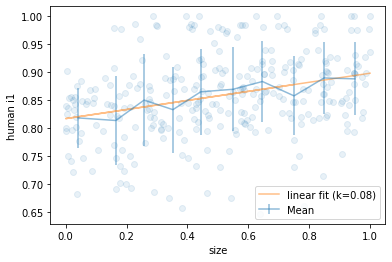

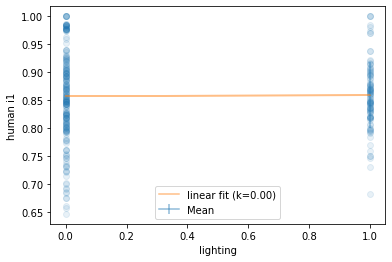

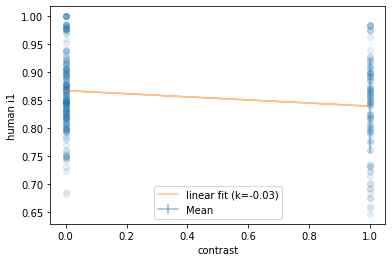

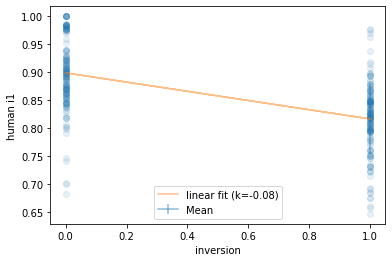

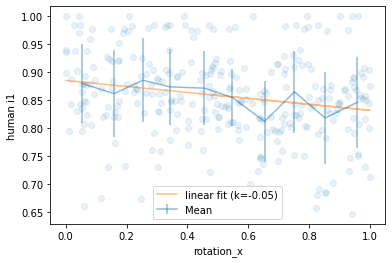

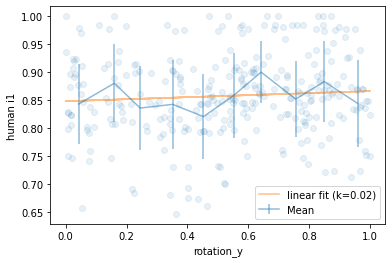

In [17]:
plot_bins(v_size_full, human_i1, 'size', 'human i1')
plot_bins(v_lighting_full, human_i1, 'lighting', 'human i1')
plot_bins(v_contrast_full, human_i1, 'contrast', 'human i1')
plot_bins(v_inversion_full, human_i1, 'inversion', 'human i1')
plot_bins(v_rotation_x_abs_full, human_i1, 'rotation_x', 'human i1')
plot_bins(v_rotation_y_abs_full, human_i1, 'rotation_y', 'human i1')

# regression

In [58]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.stats import pearsonr
from sklearn.metrics import explained_variance_score, r2_score

In [59]:
v_contrast_full.shape, v_background_full.shape

((302,), (302, 11))

In [60]:
USE_BG = False
# df = pd.DataFrame({'contrast': v_contrast_full,
#                    'inversion': v_inversion_full,
#                   'size': v_size_full})
df = pd.DataFrame({'contrast': v_contrast_full,
                   'inversion': v_inversion_full,
                   'lighting': v_lighting_full,
                   'rotation_x_abs': v_rotation_x_abs_full,
                   'rotation_y_abs': v_rotation_y_abs_full,
                   # 'rotation_x_abs': np.abs(v_rotation_x_full),
                   # 'rotation_y_abs': np.abs(v_rotation_y_full),
                   'rotation_x': v_rotation_x_full,
                   'rotation_y': v_rotation_y_full,
                   'size': v_size_full})
if USE_BG:
    for bg_index in range(v_background_full.shape[1]):
        df[f'background_{bg_index}'] = v_background_full[:, bg_index]
df.head()

,contrast,inversion,lighting,rotation_x_abs,rotation_y_abs,rotation_x,rotation_y,size
0,0.0,0.0,0.0,0.478378,0.707597,0.738752,0.146211,0.745388
1,0.0,0.0,0.0,0.696677,0.230399,0.150242,0.384826,0.450614
2,0.0,0.0,0.0,0.947496,0.012846,0.024622,0.493610,0.582110
3,0.0,0.0,0.0,0.316063,0.326527,0.340867,0.336759,0.050331
4,0.0,0.0,0.0,0.791679,0.159936,0.102661,0.420060,0.837347


In [61]:
model = LinearRegression()
# variable_name_list = ["contrast", "inversion", "lighting", "rotation_x", "rotation_y", "size"]
variable_name_list = ["contrast", "inversion", "lighting", "rotation_x_abs", "rotation_y_abs", "size"]
# variable_name_list = ["contrast", "inversion", "size"]
if USE_BG:
    for bg_index in range(v_background_full.shape[1]):
        variable_name_list.append(f"background_{bg_index}")
X = df[variable_name_list].to_numpy()

In [62]:
import statsmodels.api as sm
def subset_upright_5rep_604(array): # (5, 604) to (5, 200)
    return np.concatenate([array[:, 0:25], array[:, 50:75], 
                            array[:, 151:151+25], array[:, 151+50:151+75], 
                            array[:, 302:302+25], array[:, 302+50:302+75], 
                            array[:, 302+151:302+151+25], array[:, 302+151+50:302+151+75] ], axis=1)

def subset_upright_5rep_604_axis0(array): # (5, 604) to (5, 200)
    return np.concatenate([array[0:25, :], array[50:75, :], 
                            array[151:151+25, :], array[151+50:151+75, :], 
                            array[302:302+25, :], array[302+50:302+75, :], 
                            array[302+151:302+151+25, :], array[302+151+50:302+151+75, :] ], axis=0)

In [63]:
# bio_name = ['human', 'marmoset'] + model_name_list
# bio_i1_5rep_list = [human_i1_5rep, marmoset_i1_5rep] + model_i1_5rep_list
# bio_i1_list = [human_i1, marmoset_i1] + model_i1_list

bio_name = ['human'] + model_name_list
bio_i1_5rep_list = [human_i1_5rep] + model_i1_5rep_list
bio_i1_list = [None] + model_i1_list
r2_list = []
all_sig_list = []
upright_only = True

for index_bio in range(len(bio_name)):
    
    # with noise correction
    bio_i1 = bio_i1_5rep_list[index_bio]
    assert(bio_i1.shape==(5, 604))
    if upright_only: 
        bio_i1 = subset_upright_5rep_604(bio_i1)
    r_corrected_list = []
    r_internal_bio_list = []
    r_internal_model_list = []
    coef_avg = np.zeros(len(variable_name_list))
    
    for i_rep in range(5):
        if upright_only: 
            y_0 = bio_i1[i_rep][:100]
            y_1 = bio_i1[i_rep][100:]
            inputs = subset_upright_5rep_604_axis0(X)
        else:
            y_0 = bio_i1[i_rep][:302]
            y_1 = bio_i1[i_rep][302:]
            inputs = X

        # fit regression
        model.fit(inputs, y_0)
        y_pred_0 = model.predict(inputs)
        coef_0 = model.coef_
        model.fit(inputs, y_1)
        y_pred_1 = model.predict(inputs)
        coef_1 = model.coef_
        coef_ = (coef_0 + coef_1) / 2
        # get p values
        X2 = sm.add_constant(inputs)
        mod = sm.OLS(y_0, X2)
        fii = mod.fit()
        p_values_0 = fii.summary2().tables[1]['P>|t|']
        mod = sm.OLS(y_1, X2)
        fii = mod.fit()
        p_values_1 = fii.summary2().tables[1]['P>|t|']
        p_values = (p_values_0 + p_values_0) / 2
        # calc r
        r_0, _ = pearsonr(y_0, y_pred_1) 
        r_1, _ = pearsonr(y_1, y_pred_0) 
        r_2, _ = pearsonr(y_0, y_1) 
        r_3, _ = pearsonr(y_pred_0, y_pred_1) 

        # calc noise-corrected r2
        _r_corrected = 0.5 * (r_0 + r_1) / np.sqrt(r_2 * r_3)

        # record
        r_corrected_list.append(_r_corrected)
        r_internal_bio_list.append(r_2)
        r_internal_model_list.append(r_3)
        coef_avg += coef_
        
    print(f"{bio_name[index_bio]}\tp values: ")
    sig_list = []
    for key, value in p_values.items():
        print(f"{key}, %.4f" % (value))
        if value>0.05:
            sig_list.append(0)
        elif value>0.01:
            sig_list.append(1)
        else:
            sig_list.append(2)
    all_sig_list.append(sig_list[1:])
    
    coef_avg /= len(variable_name_list)
    r_corrected = np.mean(r_corrected_list)
    print(f"corrected\t r2: %.6f, r: %.6f" % (r_corrected**2, r_corrected))
    for var_index in range(len(variable_name_list)):
        print(f"{variable_name_list[var_index]} coef: %.4f" % (coef_avg[var_index]))
    # print("bio internal: %.2f, model internal: %.2f" % (np.mean(r_internal_bio_list), np.mean(r_internal_model_list)))
    print()
    r2_list.append(r_corrected**2)
    # # w/o noise correction
    # y = bio_i1_list[index_bio]
    # model.fit(X, y)
    # r_sq = model.score(X, y)
    # coef_ = model.coef_
    # print(f"{bio_name[index_bio]}\t w/o correction\t r2: %.2f, r: %.2f" % (r_sq, np.sqrt(r_sq)))
    # r_internal_consistency = np.mean(r_internal_bio_list)
    # print(f"{bio_name[index_bio]}\t divide-by-cons\t r2: %.2f, r: %.2f" % (r_sq/(r_internal_consistency**2), 
    #                                                                               np.sqrt(r_sq)/r_internal_consistency))
    # for var_index in range(len(variable_name_list)):
    #     print(f"{variable_name_list[var_index]} coef: %.4f" % (coef_[var_index]))
        
    print()

human	p values: 
const, 0.0000
x1, 0.0000
x2, 0.0000
x3, 0.0048
x4, 0.1871
x5, 0.0424
x6, 0.0000
corrected	 r2: 0.557408, r: 0.746598
contrast coef: 0.0000
inversion coef: -0.0000
lighting coef: -0.0251
rotation_x_abs coef: -0.0267
rotation_y_abs coef: 0.0388
size coef: 0.0823


rn50_preIN_texture_sizeVar_best	p values: 
const, 0.0000
x1, 0.0000
x2, 0.0018
x3, 0.7387
x4, 0.3217
x5, 0.3889
x6, 0.0036
corrected	 r2: 0.115080, r: 0.339234
contrast coef: 0.0000
inversion coef: -0.0000
lighting coef: -0.0034
rotation_x_abs coef: 0.0238
rotation_y_abs coef: -0.0231
size coef: 0.0833


rn50_preIN_notexture_sizeVar_best	p values: 
const, 0.0000
x1, 0.0019
x2, 0.0161
x3, 0.5251
x4, 0.0423
x5, 0.1325
x6, 0.0614
corrected	 r2: 0.099031, r: 0.314692
contrast coef: 0.0000
inversion coef: -0.0000
lighting coef: -0.0165
rotation_x_abs coef: 0.0871
rotation_y_abs coef: -0.0715
size coef: 0.0902


resnet50-trained-pretrained-vbsl	p values: 
const, 0.0000
x1, 0.0017
x2, 0.0010
x3, 0.3457
x4, 0.3039
x5, 

In [56]:
model_name_list, all_sig_list

(['resnet50',
  'pixel',
  'rn50_preIN_texture_sizeVar_best',
  'rn50_preIN_notexture_sizeVar_best',
  'resnet50-trained-pretrained-vbsl',
  'rn50_vbsl-dist-ft_epoch15',
  'rn50_FromScratch_texture_sizeVar_best',
  'rn50_FromScratch_notexture_sizeVar_best',
  'resnet50-trained-scratch-vbsl'],
 [[2, 2, 2, 0, 1, 2],
  [2, 2, 0, 0, 0, 0],
  [0, 1, 0, 0, 0, 0],
  [2, 2, 0, 0, 0, 2],
  [2, 1, 0, 1, 0, 0],
  [2, 2, 0, 0, 0, 0],
  [2, 0, 0, 2, 0, 2],
  [1, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0],
  [2, 0, 0, 2, 0, 0]])

In [42]:
r2_list

[0.5574078447413022,
 0.020509462953826663,
 0.11507955498944343,
 0.09903102126641726,
 0.023175603876989543,
 0.3050484448018072,
 0.03911456850875429,
 0.037361151792908255,
 0.13274868107479101]

In [41]:
model = LinearRegression()
model.fit(X, y)
model.coef_

array([-0.03222996, -0.08071227, -0.00950545, -0.04384444,  0.02398059,
        0.07186096])

In [44]:
X2 = sm.add_constant(X)
mod = sm.OLS(y, X2)
fii = mod.fit()
fii.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.445    
Dependent Variable: y                AIC:                -876.8615
Date:               2023-02-01 14:10 BIC:                -850.8885
No. Observations:   302              Log-Likelihood:     445.43   
Df Model:           6                F-statistic:        41.27    
Df Residuals:       295              Prob (F-statistic): 2.15e-36 
R-squared:          0.456            Scale:              0.0031376
------------------------------------------------------------------
                   Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
const              0.8854   0.0122  72.7728 0.0000  0.8615  0.9093
contrast          -0.0322   0.0079  -4.0828 0.0001 -0.0478 -0.0167
inversion         -0.0807   0.0065 -12.5085 0.0000 -0.0934 -0.0680
lighting          -0.0095   0.0079  -1.1993 0.2314 -0.0251  0.0061
rotation_x_abs    -0.0438   0.0110  -3.9946 0.0001 -0.0654 -0.0222
rotation_y_abs     0.0240   0.0113   2.1302 0.0340  0.0018  0.0461
size               0.0719   0.0114   6.3266 0.0000  0.0495  0.0942
------------------------------------------------------------------
Omnibus:              2.837         Durbin-Watson:           1.889
Prob(Omnibus):        0.242         Jarque-Bera (JB):        2.581
Skew:                 -0.162        Prob(JB):                0.275
Kurtosis:             3.316         Condition No.:           8    
==================================================================

"""

# vis

In [43]:
len(model_ReadableNames), len(mean_list)

(12, 13)

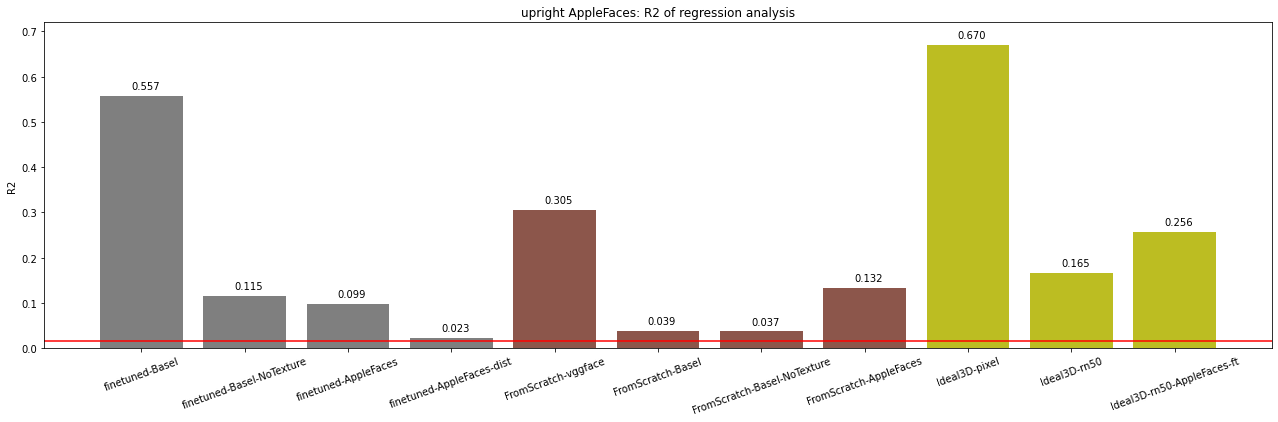

In [67]:
# plot r2 - all
model_ReadableNames = ['finetuned-Basel', 'finetuned-Basel-NoTexture', 'finetuned-AppleFaces', 'finetuned-AppleFaces-dist'] + \
                          ['FromScratch-vggface', 'FromScratch-Basel', 'FromScratch-Basel-NoTexture', 'FromScratch-AppleFaces'] + \
                          ['Ideal3D-pixel', 'Ideal3D-rn50', 'Ideal3D-rn50-AppleFaces-ft']
color_list = ['tab:grey'] * 4 + ['tab:brown'] * 4 + ['tab:olive'] * 3
# read
mean_list = r2_list + [0.670058, 0.165788, 0.256404]
    
# plot
plt.figure(figsize=(2*len(model_ReadableNames), 6))
plt.bar(model_ReadableNames, mean_list, color=color_list)
for i, v in enumerate(mean_list):
    plt.text(i-0.1, v+0.015, str(v)[:5])
plt.ylim([0, 0.72])
plt.xticks(rotation=20)
plt.title(f"upright AppleFaces: R2 of regression analysis")
plt.ylabel("R2")
data_name = data_root.split("/")[-2]
plt.axhline(y=0.015968, color='r', linestyle='-', label="resnet50")

plt.savefig(f"./figs/ideal3d_r2_against_all.pdf", dpi=500)
plt.show()

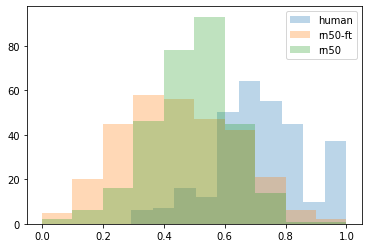

In [149]:
plt.hist(human_i1, bins=10, alpha=.3, label='human')
plt.hist(model_rn50_finetuned_i1, bins=10, alpha=.3, label='rn50-ft')
plt.hist(model_rn50_i1, bins=10, alpha=.3, label='rn50')
plt.legend()

In [164]:
y = model_rn50_finetuned_i1
model.fit(X, y)
r_sq = model.score(X, y)
y_pred = model.predict(X)
coef_ = model.coef_

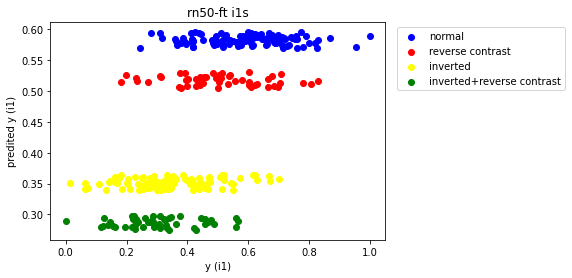

r=0.64


In [165]:
plt.scatter(y[(X['inversion']==0) & (X['contrast']==0)], 
            y_pred[(X['inversion']==0) & (X['contrast']==0)], 
            color='blue', label='normal')
plt.scatter(y[(X['inversion']==0) & (X['contrast']==1)], 
            y_pred[(X['inversion']==0) & (X['contrast']==1)], 
            color='red', label='reverse contrast')
plt.scatter(y[(X['inversion']==1) & (X['contrast']==0)], 
            y_pred[(X['inversion']==1) & (X['contrast']==0)], 
            color='yellow', label='inverted')
plt.scatter(y[(X['inversion']==1) & (X['contrast']==1)], 
            y_pred[(X['inversion']==1) & (X['contrast']==1)], 
            color='green', label='inverted+reverse contrast')

plt.xlabel("y (i1)")
plt.ylabel("predited y (i1)")
plt.title("rn50-ft i1s")
plt.legend(bbox_to_anchor=[1.02,1])
plt.show()
print("r=%.2f" % (pearsonr(y, y_pred)[0]))

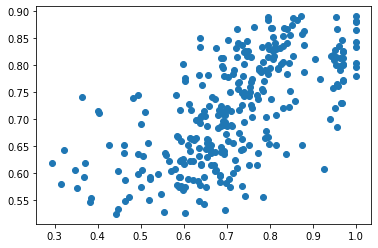

In [162]:
y = human_i1
model.fit(X, y)
r_sq = model.score(X, y)
y_pred = model.predict(X)
coef_ = model.coef_

plt.scatter(y, y_pred)
plt.show()

In [ ]:
#